# Binary merger trees
We want to count the number of possible merger trees with N equal-mass BHs. Left-right reflection should be a local simmetry: the shape of a tree does not change if at any node we switch the linked paths.

We can define a "base" of two fundamental tree shapes (zero and one), from which we can build all possible merger trees for each N:

<img src="img/trees_image.png" width="800">

To build a tree with N BHs we can follow this algorithm (starting with N=3, the first not trivial tree):
- look at the trees with N-1
- add a "zero":create a new branching with a single BH parent
- OR tranform a "zero" into a "one": create a new branching "promoting" a BH to a higher level and couple it with a new one


When reaching N = 6, we have to take into account the possibility to form a tree combining two smaller ones with N = 3. From now on we will call:
-  "branches" the trees built using the previous algorhitm as they are the fundamental blocks
- "combinations" the trees built combining other trees (that could be branches, or combinations as well)

We will add a new combination "layer" every time N is a multiple of 3

## Counting possible shapes
First we count possible branches, and see that they follow the Fibonacci sequence.

For each value of N we count:
- +1 for the first tree (the code is made of $N-2$ zeros)
- permutations of N-4 zeros and 1 one
- permutations of N-5 zeros and 2 ones
- ...

We obtain the following formula:

$$ T(N) = 1 + \sum_{i=1}^{int(\frac{N-2}{2})} \frac{(N-2-1)!}{i!(N-2-2i)!}$$

Which gives the fibonacci sequence (not demonstrated here, just looked at the values)

In [97]:
import numpy as np
from math import factorial as fact
from more_itertools import distinct_permutations as perm


def elem(N,i): # element of the sum
    return fact(N-2-i)/fact(i)/fact(N-2-2*i)

N_list = np.arange(3,100)
n_trees_list = []

# Formula computed from permutations
for N in N_list:
    i_max = int((N-2)/2) 
    i_list = np.arange(1, i_max+1)
    n_trees = 1
    for i in i_list:
        n_trees += elem(N,i)
    n_trees_list.append(int(n_trees))

# Fibonacci sequence
phi = (1 + np.sqrt(5))/2
psi = (1 - np.sqrt(5))/2
n_list = np.arange(3,30)
fibo_list = [int((phi**n - psi**n)/np.sqrt(5)) for n in n_list]

We plot the result and compare it to $y = 2^{N}$

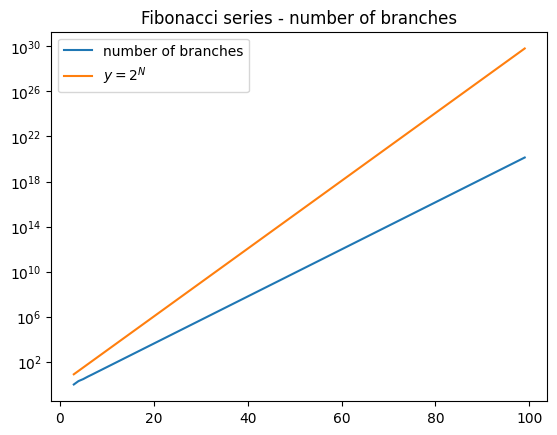

In [98]:
import pylab as plt

plt.plot(N_list, n_trees_list, label='number of branches')
plt.plot(N_list, np.exp2(N_list), label = r'$y = 2^{N}$' )
plt.yscale('log')
plt.title('Fibonacci series - number of branches')
plt.legend()

To compute total number of merger trees we need to add  combinations.

In [100]:
# compute number of combinations of primary branches

# from scipy.special import binom  

# c_list = []
# for i, t in enumerate(n_trees_list):
#     N = i + 3
#     N_max = int(N/2) +1
#     c = 0
#     if N < 6: c_list.append(c)
#     else :
#         for j in np.arange(3,N_max):
#             if j == N-j : 
#                 c += int(binom(n_trees_list[j-3]+1,2))
#                 continue
#             c += int(n_trees_list[j-3] * n_trees_list[N-j-3])
        
#         c_list.append(c)

In [77]:
# compute number of trees, combinations are added directly at each step

from math import factorial as fact
from more_itertools import distinct_permutations as perm
from scipy.special import binom  
import numpy as np

def elem(N,i): 
    return fact(N-2-i)/fact(i)/fact(N-2-2*i)

N_list = np.arange(3, 120)
n_trees_list = []

for N in N_list:
    i_max = int((N-2)/2) + 1
    i_list = np.arange(1, i_max)
    n_trees = 1
    for i in i_list:
        n_trees += int(elem(N,i)) # Number of primary trees

    if N > 5: # we compute the possible combinations
        N_max = int(N/2) +1
        for j in np.arange(3,N_max):
            if j == N-j : #--------------------------------------------------------------------------------- we use combinations when we combine trees from the same N to avoid double counting
                n_trees += int(binom(n_trees_list[j-3]+1,2))
                continue
            n_trees += int(n_trees_list[j-3] * n_trees_list[N-j-3]) #----------------- number of couples after performing a carthesian product

    n_trees_list.append(int(n_trees))

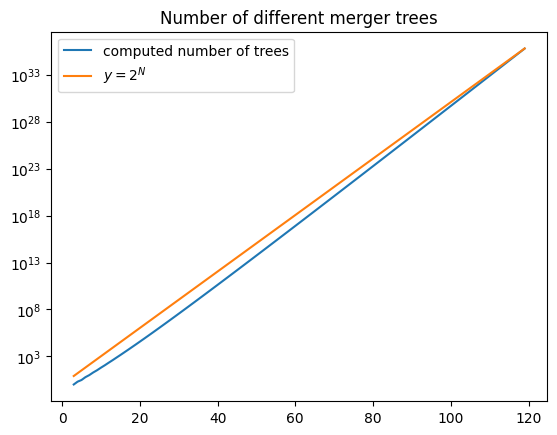

In [88]:
import pylab as plt

plt.plot(N_list, n_trees_list, label='computed number of trees')
plt.plot(N_list, np.exp2(N_list), label = r'$y = 2^{N}$' )
plt.yscale('log')
plt.title('Number of different merger trees')
plt.legend()

The function to compute the binomial coefficient is safe up until about N = 120. Anyway, up to this level, the trend seems to be exponential.

### What if they have different masses?
Then we have to count also permutations of the "leaves", where one leaf is either a couple of parent BHs merging, or a single parent BH that will merge with the son of other mergers. So it's a matter of computing the possible different trees and then count their leaves.



# Computing merger trees
Now we use the algorithm described above to build the codes of every possbile tree

In [101]:
import numpy as np
from more_itertools import distinct_permutations
from astroML.utils.decorators import pickle_results

# @pickle_results('branches.pkl')
def save_branches(N_list):
    '''Returns branches list, long as N_list. For each N contains a list of branches (saved as lists of ordered zeros and ones)'''

    tot_branches = []
    N_list = np.arange(3,20)

    for N in N_list:
        branch_list = []
        
        first = np.full(N-2, 0)
        branch_list.append(first.tolist()) # saving first tree

        i_max = int((N-2)/2) 
        for i in np.arange(1, i_max+1): # Every i is a different number of ones
            tree = np.copy(first[i:])
            tree[:i] = 1
            p = [list(x) for x in distinct_permutations(tree)] 
            for branch in p: branch_list.append(branch)   

        tot_branches.append(branch_list)
        
    return tot_branches


N_list = np.arange(3,9)

branches = save_branches(N_list) # Returns branche list, long as N_list. For each N contains a list of branches (saved as lists of ordered zeros and ones)
# branches
    

In [19]:
# from itertools import product, combinations_with_replacement

# def combine_branches(tot_branches):

#     branch_combinations = []
#     N_list = np.arange(6,len(branches)+3)
#     for N in N_list:
#         N_max = int(N/2) +1
#         comb_list = []

#         for n  in np.arange(3, N_max): 
#                 i = n - 3
#                 j = N - n -3
#                 if i == j:  p = combinations_with_replacement(branches[i],2)
#                 else:  p = product(branches[i],branches[j])
#                 for comb in p: comb_list.append(list(comb))
                
#         # for x in comb_list:  branch_combinations.append(x) # Not dividing for different N values
#         branch_combinations.append(comb_list) #Dividing for different N values

#     return branch_combinations

# combinations = combine_branches(branches)

In [18]:
# from copy import deepcopy

# def add_combinations(branches, combinations):

#     N_list = np.arange(6,len(branches)+3)
#     copy = deepcopy(branches)
#     for i,N in enumerate(N_list):
#         for x in combinations[i]: copy[i+3].append(x)

#     return copy

# trees = add_combinations(branches, combinations)



Now we update the algorithm to count also combinations of smaller trees:


In [62]:
import numpy as np
from more_itertools import distinct_permutations as perm
from astroML.utils.decorators import pickle_results
from itertools import product, combinations_with_replacement

tot_branches = []
N_list = np.arange(3,20)



for N in N_list:
    branch_list = []
    i_max = int((N-2)/2) 
    i_list = np.arange(1, i_max+1)

    first = np.full(N-2, 0)
    branch_list.append(first.tolist())

    for i in i_list: #computing primary branches
        tree = np.copy(first[i:])
        tree[:i] = 1
        p = perm(tree)
        for branch in p: branch_list.append(list(branch)) # branch_list for every N, we need that to compute combinations

    # Computing combinations
    if N > 5: 
        N_max = int(N/2) +1 

        for n  in np.arange(3, N_max): 
                i = n - 3
                j = N - n -3
                if i == j:  p = combinations_with_replacement(tot_branches[i],2)
                else:  p = product(tot_branches[i],tot_branches[j]) # We use the trees  
                for comb in p: branch_list.append(list(comb)) # We directly add the combination to the branch list

    tot_branches.append(branch_list) # List of all possible trees

In [102]:
import numpy as np
from more_itertools import distinct_permutations as perm
from astroML.utils.decorators import pickle_results
from itertools import product, combinations_with_replacement

def compute_trees(N_list):
    '''Returns trees list, long as N_list. For each N contains a list of trees (saved as lists of ordered zeros and ones)'''

    tot_branches = []
    for N in N_list:
        branch_list = []
        i_max = int((N-2)/2) 
        i_list = np.arange(1, i_max+1)

        first = np.full(N-2, 0)
        branch_list.append(first.tolist())

        for i in i_list: #computing primary branches
            tree = np.copy(first[i:])
            tree[:i] = 1
            p = perm(tree)
            for branch in p: branch_list.append(list(branch)) # branch_list for every N, we need that to compute combinations

        # Computing combinations
        if N > 5: 
            N_max = int(N/2) +1 

            for n  in np.arange(3, N_max): 
                i = n - 3
                j = N - n -3
                if i == j:  p = combinations_with_replacement(tot_branches[i],2)
                else:  p = product(tot_branches[i],tot_branches[j]) # We use the trees  
                for comb in p: branch_list.append(list(comb)) # We directly add the combination to the branch list

        tot_branches.append(branch_list) # List of all possible trees

    return tot_branches

#________________________________________________#


N_list = np.arange(3,20)
total_trees = compute_trees(N_list)

In [108]:
total_trees[4]

[[0, 0, 0, 0, 0],
 [0, 0, 0, 1],
 [0, 0, 1, 0],
 [0, 1, 0, 0],
 [1, 0, 0, 0],
 [0, 1, 1],
 [1, 0, 1],
 [1, 1, 0],
 [[0], [0, 0]],
 [[0], [1]]]

Eureka!

It would be neat to add a feature to draw a tree given the code output

### Future work: Counting trees with different BH masses


